In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import random

# PyTorch (no special installation needed!)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# GPU device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ Number of GPUs: {torch.cuda.device_count()}")
    print(f"✓ CUDA Version: {torch.version.cuda}")

✓ Using device: cuda
✓ GPU: Tesla T4
✓ Number of GPUs: 2
✓ CUDA Version: 12.6


## 1. Problem Description and Data Overview

### 1.1 Challenge Problem

This project addresses the task of **artistic style transfer** using Generative Adversarial Networks (GANs). Specifically, we aim to transform regular photographs into paintings that mimic the distinctive style of Claude Monet, the renowned French Impressionist painter.

**Problem Type:** Unpaired image-to-image translation  
**Approach:** CycleGAN architecture  
**Evaluation Metric:** MiFID (Memorization-informed Fréchet Inception Distance) score

### 1.2 Generative Deep Learning Models

We'll be using **CycleGAN**, a type of Generative Adversarial Network that:
- Works with unpaired datasets (we don't need photo-painting pairs)
- Uses cycle consistency to preserve content while changing style
- Employs two generators (photo→Monet and Monet→photo) and two discriminators

**Key Components:**
1. **Generator G:** Transforms photos → Monet-style paintings
2. **Generator F:** Transforms Monet paintings → photos (for cycle consistency)
3. **Discriminator D_Y:** Distinguishes real Monet paintings from generated ones
4. **Discriminator D_X:** Distinguishes real photos from generated ones

### 1.3 Dataset Description

**Dataset source:** Kaggle - GAN Getting Started Competition

The dataset will contain:
- **Monet paintings:** Training set of Monet's artwork
- **Photos:** Training set of regular photographs
- **Image dimensions:** Typically 256×256 or 512×512 pixels
- **Format:** JPG/PNG images
- **Number of images:** [To be filled after loading data]

We'll examine the exact structure, size, and characteristics in the EDA section below.

## 2. Setup and Imports

In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import zipfile

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

# For reproducibility
import random

# Visualization
from IPython.display import Image as IPImage, display

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 3. Exploratory Data Analysis (EDA)

### 3.1 Load and Examine Dataset Structure

In [4]:
# Output directories
OUTPUT_DIR = Path('/kaggle/working/outputs')
OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / 'generated_images').mkdir(exist_ok=True)
(OUTPUT_DIR / 'checkpoints').mkdir(exist_ok=True)

DATA_DIR = Path('../input/gan-getting-started')
MONET_DIR = DATA_DIR / 'monet_jpg'
PHOTO_DIR = DATA_DIR / 'photo_jpg'

# Create output directories
OUTPUT_DIR = Path('../working')
OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / 'generated_images').mkdir(exist_ok=True)
(OUTPUT_DIR / 'checkpoints').mkdir(exist_ok=True)

# Count images
monet_images = sorted(list(MONET_DIR.glob('*.jpg')))
photo_images = sorted(list(PHOTO_DIR.glob('*.jpg')))

print(f"Number of Monet paintings: {len(monet_images)}")
print(f"Number of photos: {len(photo_images)}")
print(f"\nMonet directory: {MONET_DIR}")
print(f"Photo directory: {PHOTO_DIR}")

Number of Monet paintings: 300
Number of photos: 7038

Monet directory: ../input/gan-getting-started/monet_jpg
Photo directory: ../input/gan-getting-started/photo_jpg


### 3.2 Image Dimensions and Properties

In [5]:
# Sample a few images to check dimensions
def get_image_info(image_paths, num_samples=10):
    """Get basic info about images"""
    info = []
    for img_path in image_paths[:num_samples]:
        img = Image.open(img_path)
        info.append({
            'filename': img_path.name,
            'width': img.size[0],
            'height': img.size[1],
            'mode': img.mode,
            'format': img.format
        })
    return pd.DataFrame(info)

print("Monet Paintings Info:")
monet_info = get_image_info(monet_images)
display(monet_info.head())

print("\nPhoto Info:")
photo_info = get_image_info(photo_images)
display(photo_info.head())

print("\nImage Statistics:")
print(f"Monet - Mean size: {monet_info['width'].mean():.0f} x {monet_info['height'].mean():.0f}")
print(f"Photo - Mean size: {photo_info['width'].mean():.0f} x {photo_info['height'].mean():.0f}")

Monet Paintings Info:


filename  width  height mode format
0  000c1e3bff.jpg    256     256  RGB   JPEG
1  011835cfbf.jpg    256     256  RGB   JPEG
2  0260d15306.jpg    256     256  RGB   JPEG
3  049e293b93.jpg    256     256  RGB   JPEG
4  05144e306f.jpg    256     256  RGB   JPEG


Photo Info:


filename  width  height mode format
0  00068bc07f.jpg    256     256  RGB   JPEG
1  000910d219.jpg    256     256  RGB   JPEG
2  000ded5c41.jpg    256     256  RGB   JPEG
3  00104fd531.jpg    256     256  RGB   JPEG
4  001158d595.jpg    256     256  RGB   JPEG


Image Statistics:
Monet - Mean size: 256 x 256
Photo - Mean size: 256 x 256


### 3.3 Visualize Sample Images

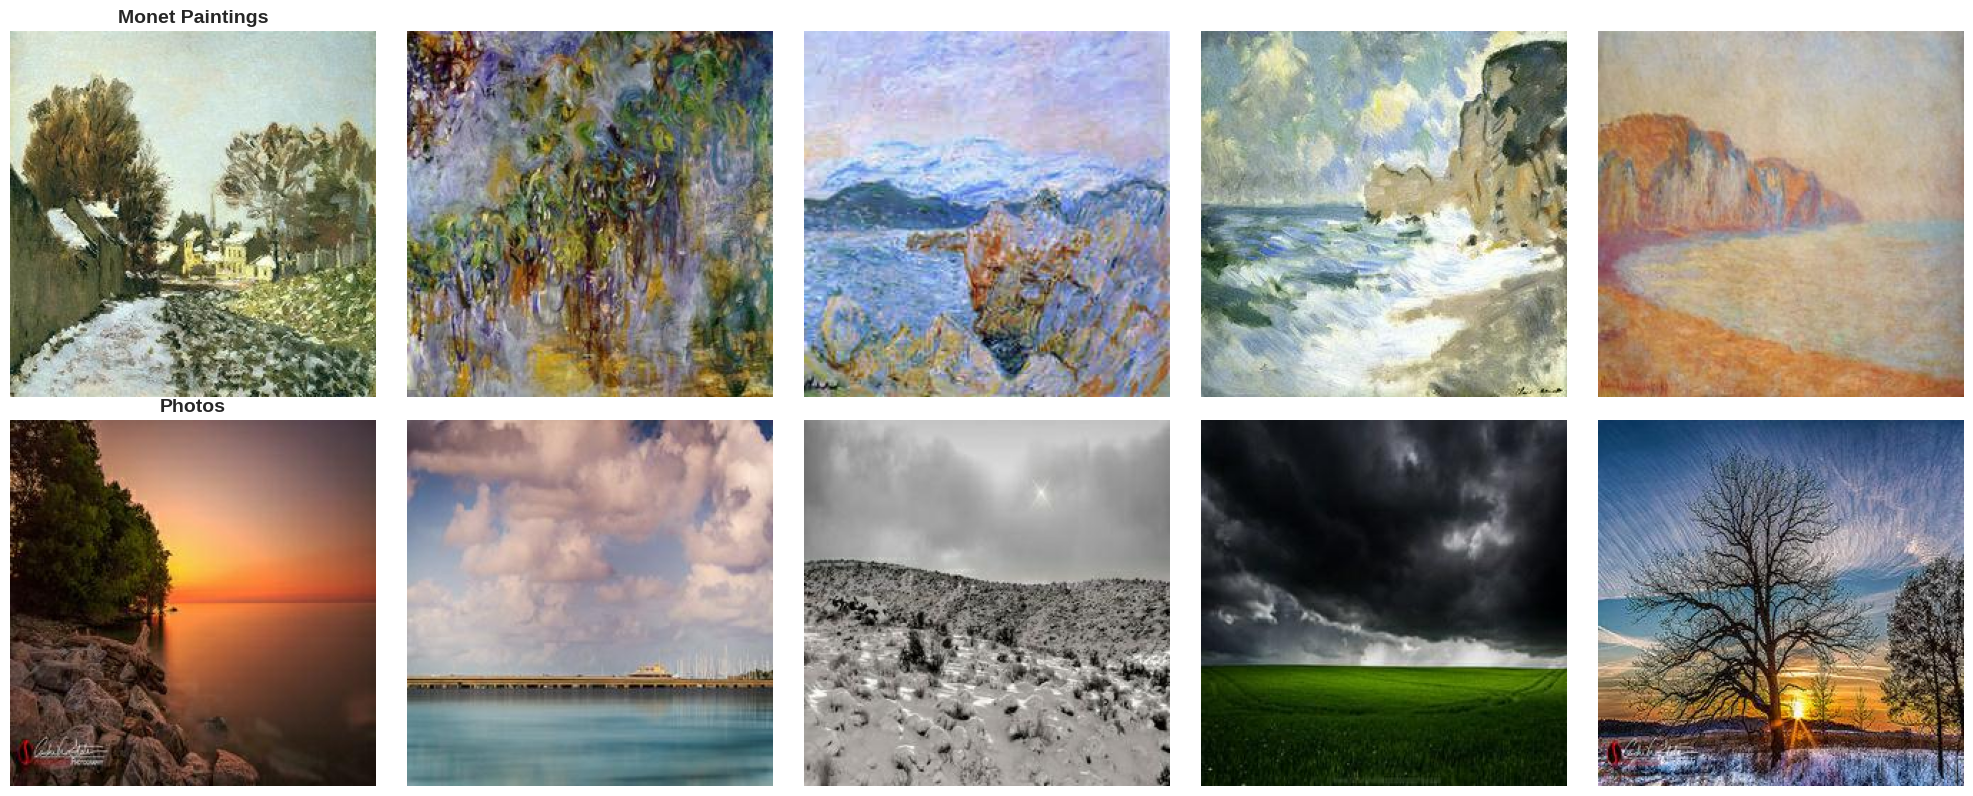

In [5]:
def plot_sample_images(monet_paths, photo_paths, n_samples=5):
    """Display sample Monet paintings and photos side by side"""
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))
    
    # Plot Monet paintings
    for i in range(n_samples):
        img = Image.open(monet_paths[i])
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Monet Paintings', fontsize=14, fontweight='bold')
    
    # Plot photos
    for i in range(n_samples):
        img = Image.open(photo_paths[i])
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Photos', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

# Randomly sample images
sample_indices = random.sample(range(len(monet_images)), 5)
plot_sample_images(
    [monet_images[i] for i in sample_indices],
    [photo_images[i] for i in sample_indices]
)

### 3.4 Pixel Intensity Distribution Analysis

Analyzing Monet paintings...


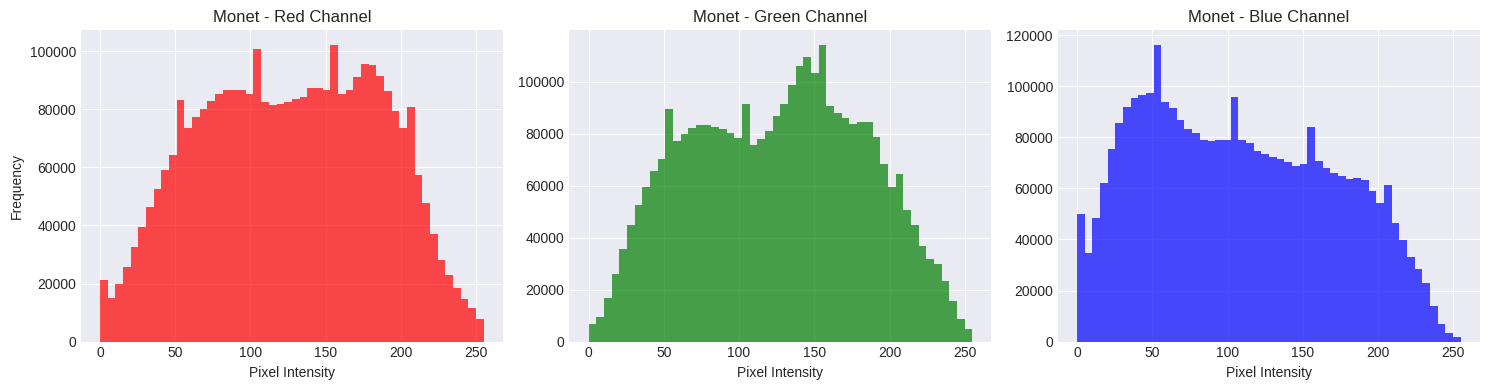

Monet RGB means: R=126.5, G=125.4, B=108.4

Analyzing photos...


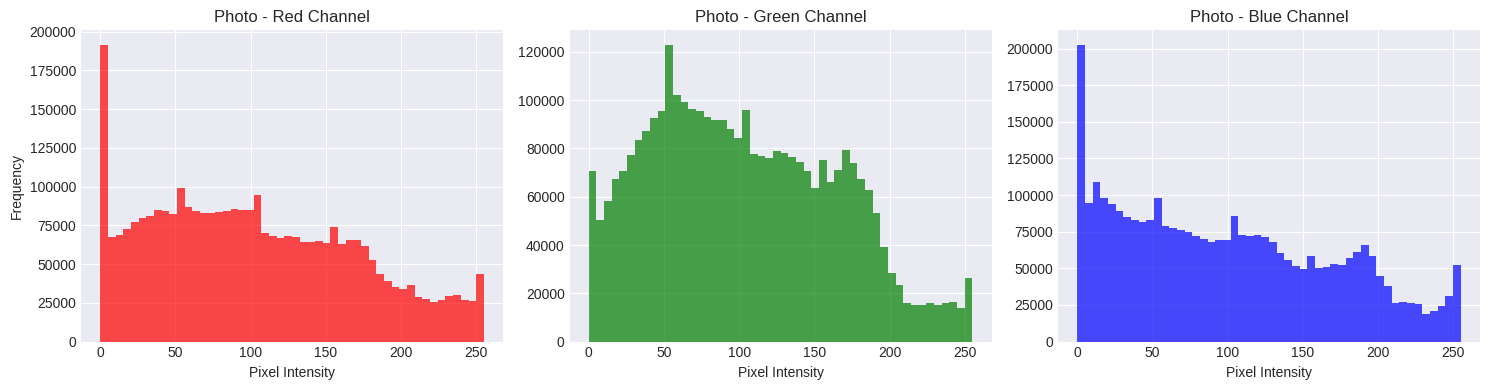

Photo RGB means: R=102.5, G=103.3, B=99.8


In [6]:
def analyze_pixel_distribution(image_paths, label, n_samples=50):
    """Analyze RGB channel distributions"""
    r_vals, g_vals, b_vals = [], [], []
    
    for img_path in random.sample(image_paths, min(n_samples, len(image_paths))):
        img = np.array(Image.open(img_path))
        r_vals.extend(img[:,:,0].flatten())
        g_vals.extend(img[:,:,1].flatten())
        b_vals.extend(img[:,:,2].flatten())
    
    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(r_vals, bins=50, color='red', alpha=0.7)
    axes[0].set_title(f'{label} - Red Channel')
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(g_vals, bins=50, color='green', alpha=0.7)
    axes[1].set_title(f'{label} - Green Channel')
    axes[1].set_xlabel('Pixel Intensity')
    
    axes[2].hist(b_vals, bins=50, color='blue', alpha=0.7)
    axes[2].set_title(f'{label} - Blue Channel')
    axes[2].set_xlabel('Pixel Intensity')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'{label.lower()}_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'r_mean': np.mean(r_vals),
        'g_mean': np.mean(g_vals),
        'b_mean': np.mean(b_vals),
        'r_std': np.std(r_vals),
        'g_std': np.std(g_vals),
        'b_std': np.std(b_vals)
    }

print("Analyzing Monet paintings...")
monet_stats = analyze_pixel_distribution(monet_images, 'Monet')
print(f"Monet RGB means: R={monet_stats['r_mean']:.1f}, G={monet_stats['g_mean']:.1f}, B={monet_stats['b_mean']:.1f}")

print("\nAnalyzing photos...")
photo_stats = analyze_pixel_distribution(photo_images, 'Photo')
print(f"Photo RGB means: R={photo_stats['r_mean']:.1f}, G={photo_stats['g_mean']:.1f}, B={photo_stats['b_mean']:.1f}")

### 3.5 EDA Summary

**Key Findings:**
- Dataset size: [Fill in] Monet paintings, [Fill in] photos
- Image resolution: [Fill in] × [Fill in] pixels
- Color distributions: [Describe differences between Monet and photos]
- Monet style characteristics: [Describe visual patterns - impressionistic, softer edges, specific color palettes]

**Implications for Model:**
- Need to preserve image structure while changing artistic style
- Should focus on color palette transformation and brush stroke simulation
- Cycle consistency will be crucial to maintain content

## 4. Data Preprocessing and Dataset Creation

### 4.1 Define Transformations

In [5]:
IMG_SIZE = 256
BATCH_SIZE = 1  
NUM_WORKERS = 2
NUM_EPOCHS = 200  
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
SAVE_INTERVAL = 10
SAMPLE_INTERVAL = 5

print(f"Monet images: {len(list(MONET_DIR.glob('*.jpg')))}")
print(f"Photo images: {len(list(PHOTO_DIR.glob('*.jpg')))}")

# Hyperparameters
IMG_SIZE = 256  # CycleGAN typically uses 256×256
BATCH_SIZE = 1  # CycleGAN often uses batch size 1
NUM_WORKERS = 2

# Image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# For visualization (denormalize)
def denormalize(tensor):
    """Convert normalized tensor back to [0, 1] range"""
    return tensor * 0.5 + 0.5

Monet images: 300
Photo images: 7038


### 4.2 Custom Dataset Class

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def denormalize(tensor):
    return tensor * 0.5 + 0.5

class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_images = sorted(list(Path(monet_dir).glob('*.jpg')))
        self.photo_images = sorted(list(Path(photo_dir).glob('*.jpg')))
        self.transform = transform
        self.length = max(len(self.monet_images), len(self.photo_images))
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        monet_idx = idx % len(self.monet_images)
        photo_idx = idx % len(self.photo_images)
        
        monet_img = Image.open(self.monet_images[monet_idx]).convert('RGB')
        photo_img = Image.open(self.photo_images[photo_idx]).convert('RGB')
        
        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)
        
        return {'monet': monet_img, 'photo': photo_img}

# Create dataset and dataloader
dataset = ImageDataset(MONET_DIR, PHOTO_DIR, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

Dataset size: 7038
Number of batches: 7038


### 4.3 Verify Data Loading

Monet batch shape: torch.Size([1, 3, 256, 256])
Photo batch shape: torch.Size([1, 3, 256, 256])
Value range: [-1.00, 1.00]


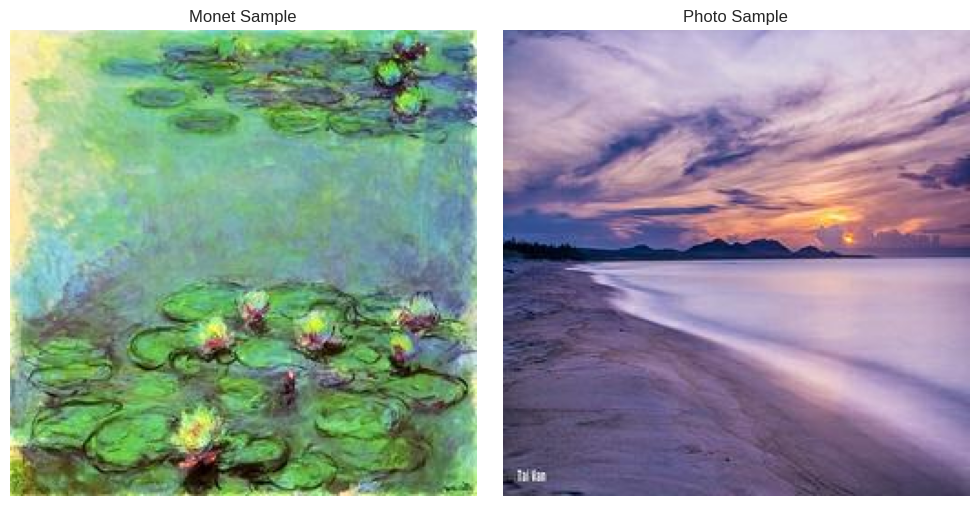

In [7]:
# Test the dataloader
batch = next(iter(dataloader))
print(f"Monet batch shape: {batch['monet'].shape}")
print(f"Photo batch shape: {batch['photo'].shape}")
print(f"Value range: [{batch['monet'].min():.2f}, {batch['monet'].max():.2f}]")

# Visualize a batch
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(denormalize(batch['monet'][0]).permute(1, 2, 0).cpu())
axes[0].set_title('Monet Sample')
axes[0].axis('off')

axes[1].imshow(denormalize(batch['photo'][0]).permute(1, 2, 0).cpu())
axes[1].set_title('Photo Sample')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 5. Model Architecture

### 5.1 Building Blocks

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_channels = 64
        out_channels = in_channels * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels * 2
        
        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_channels)]
        
        # Upsampling
        out_channels = in_channels // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels // 2
        
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
G_photo2monet = Generator().to(device)
G_monet2photo = Generator().to(device)
D_monet = Discriminator().to(device)
D_photo = Discriminator().to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.InstanceNorm2d):
        if m.weight is not None:
            nn.init.normal_(m.weight, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

G_photo2monet.apply(init_weights)
G_monet2photo.apply(init_weights)
D_monet.apply(init_weights)
D_photo.apply(init_weights)

print("✓ Models initialized!")
print(f"Generator params: {sum(p.numel() for p in G_photo2monet.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in D_monet.parameters()):,}")

✓ Models initialized!
Generator params: 11,378,179
Discriminator params: 2,764,737


### 5.2 Loss Functions

In [9]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(
    list(G_photo2monet.parameters()) + list(G_monet2photo.parameters()),
    lr=LR, betas=(BETA1, BETA2)
)
optimizer_D_monet = optim.Adam(D_monet.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_photo = optim.Adam(D_photo.parameters(), lr=LR, betas=(BETA1, BETA2))

def lr_lambda(epoch):
    return 1.0 - max(0, epoch - 100) / 100

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
scheduler_D_monet = optim.lr_scheduler.LambdaLR(optimizer_D_monet, lr_lambda=lr_lambda)
scheduler_D_photo = optim.lr_scheduler.LambdaLR(optimizer_D_photo, lr_lambda=lr_lambda)

history = {
    'G_loss': [],
    'D_monet_loss': [],
    'D_photo_loss': [],
    'cycle_loss': [],
    'identity_loss': []
}

print("Optimizers configured!")

Optimizers configured!


## 6. Training

### 6.1 Training Loop

In [11]:
def train_one_epoch(epoch):
    G_photo2monet.train()
    G_monet2photo.train()
    D_monet.train()
    D_photo.train()
    
    epoch_G_loss = 0
    epoch_D_monet_loss = 0
    epoch_D_photo_loss = 0
    epoch_cycle_loss = 0
    epoch_identity_loss = 0
    
    patch_size = None
    
    for i, batch in enumerate(dataloader):
        real_photo = batch['photo'].to(device)
        real_monet = batch['monet'].to(device)
        
        # Get discriminator output size on first iteration
        if patch_size is None:
            with torch.no_grad():
                sample_output = D_monet(real_monet)
                patch_size = sample_output.shape[-1]
                print(f"Discriminator patch size: {patch_size}x{patch_size}")
        
        # Labels for real and fake
        valid = torch.ones((real_photo.size(0), 1, patch_size, patch_size), device=device)
        fake = torch.zeros((real_photo.size(0), 1, patch_size, patch_size), device=device)
        
        # Train Generators
        optimizer_G.zero_grad()
        
        loss_identity_photo = criterion_identity(G_monet2photo(real_photo), real_photo)
        loss_identity_monet = criterion_identity(G_photo2monet(real_monet), real_monet)
        loss_identity = (loss_identity_photo + loss_identity_monet) / 2
        
        fake_monet = G_photo2monet(real_photo)
        loss_GAN_photo2monet = criterion_GAN(D_monet(fake_monet), valid)
        
        fake_photo = G_monet2photo(real_monet)
        loss_GAN_monet2photo = criterion_GAN(D_photo(fake_photo), valid)
        
        recovered_photo = G_monet2photo(fake_monet)
        loss_cycle_photo = criterion_cycle(recovered_photo, real_photo)
        
        recovered_monet = G_photo2monet(fake_photo)
        loss_cycle_monet = criterion_cycle(recovered_monet, real_monet)
        
        loss_cycle = (loss_cycle_photo + loss_cycle_monet) / 2
        
        loss_G = (loss_GAN_photo2monet + loss_GAN_monet2photo + 
                  LAMBDA_CYCLE * loss_cycle + 
                  LAMBDA_IDENTITY * loss_identity)
        
        loss_G.backward()
        optimizer_G.step()
        
        # Train Discriminator Monet
        optimizer_D_monet.zero_grad()
        
        loss_real = criterion_GAN(D_monet(real_monet), valid)
        loss_fake = criterion_GAN(D_monet(fake_monet.detach()), fake)
        loss_D_monet = (loss_real + loss_fake) / 2
        
        loss_D_monet.backward()
        optimizer_D_monet.step()
        
        # Train Discriminator Photo
        optimizer_D_photo.zero_grad()
        
        loss_real = criterion_GAN(D_photo(real_photo), valid)
        loss_fake = criterion_GAN(D_photo(fake_photo.detach()), fake)
        loss_D_photo = (loss_real + loss_fake) / 2
        
        loss_D_photo.backward()
        optimizer_D_photo.step()
        
        # Accumulate losses
        epoch_G_loss += loss_G.item()
        epoch_D_monet_loss += loss_D_monet.item()
        epoch_D_photo_loss += loss_D_photo.item()
        epoch_cycle_loss += loss_cycle.item()
        epoch_identity_loss += loss_identity.item()
        
        # Print progress
        if (i + 1) % 50 == 0:
            print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] [Batch {i+1}/{len(dataloader)}] "
                  f"[G: {loss_G.item():.4f}] [D: {(loss_D_monet.item() + loss_D_photo.item())/2:.4f}]")
    
    # Average losses
    n_batches = len(dataloader)
    history['G_loss'].append(epoch_G_loss / n_batches)
    history['D_monet_loss'].append(epoch_D_monet_loss / n_batches)
    history['D_photo_loss'].append(epoch_D_photo_loss / n_batches)
    history['cycle_loss'].append(epoch_cycle_loss / n_batches)
    history['identity_loss'].append(epoch_identity_loss / n_batches)
    
    return fake_monet, fake_photo

def save_sample_images(epoch, fake_monet, fake_photo, real_photo):
    G_photo2monet.eval()
    with torch.no_grad():
        imgs = torch.cat([real_photo[:4], fake_monet[:4]], dim=0)
        grid = make_grid(denormalize(imgs), nrow=4, padding=2)
        save_image(grid, OUTPUT_DIR / 'generated_images' / f'epoch_{epoch+1}.png')
    G_photo2monet.train()

def save_checkpoint(epoch):
    checkpoint = {
        'epoch': epoch,
        'G_photo2monet_state_dict': G_photo2monet.state_dict(),
        'G_monet2photo_state_dict': G_monet2photo.state_dict(),
        'D_monet_state_dict': D_monet.state_dict(),
        'D_photo_state_dict': D_photo.state_dict(),
        'history': history
    }
    torch.save(checkpoint, OUTPUT_DIR / 'checkpoints' / f'checkpoint_epoch_{epoch+1}.pth')
    print(f"Checkpoint saved at epoch {epoch+1}")

### 6.2 Run Training

In [ ]:
print("Starting training on GPU...")
print(f"Training for {NUM_EPOCHS} epochs")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of batches per epoch: {len(dataloader)}")
print("-" * 80)

for epoch in range(NUM_EPOCHS):
    fake_monet, fake_photo = train_one_epoch(epoch)
    
    scheduler_G.step()
    scheduler_D_monet.step()
    scheduler_D_photo.step()
    
    if (epoch + 1) % SAMPLE_INTERVAL == 0:
        real_photo_sample = next(iter(dataloader))['photo'].to(device)
        save_sample_images(epoch, fake_monet, fake_photo, real_photo_sample)
    
    if (epoch + 1) % SAVE_INTERVAL == 0:
        save_checkpoint(epoch)
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Summary:")
    print(f"  G Loss: {history['G_loss'][-1]:.4f}")
    print(f"  D Monet Loss: {history['D_monet_loss'][-1]:.4f}")
    print(f"  D Photo Loss: {history['D_photo_loss'][-1]:.4f}")
    print(f"  Cycle Loss: {history['cycle_loss'][-1]:.4f}")
    print(f"  Identity Loss: {history['identity_loss'][-1]:.4f}")
    print("-" * 80)

print("Training completed!")

Starting training on GPU...
Training for 200 epochs
Batch size: 1
Number of batches per epoch: 7038
--------------------------------------------------------------------------------
Discriminator patch size: 15x15
[Epoch 1/200] [Batch 50/7038] [G: 5.8282] [D: 0.3621]
[Epoch 1/200] [Batch 100/7038] [G: 6.7345] [D: 0.2842]
[Epoch 1/200] [Batch 150/7038] [G: 4.9908] [D: 0.3394]
[Epoch 1/200] [Batch 200/7038] [G: 4.1264] [D: 0.2886]
[Epoch 1/200] [Batch 250/7038] [G: 5.9280] [D: 0.2338]
[Epoch 1/200] [Batch 300/7038] [G: 5.9395] [D: 0.4744]
[Epoch 1/200] [Batch 350/7038] [G: 4.9007] [D: 0.2754]
[Epoch 1/200] [Batch 400/7038] [G: 5.3345] [D: 0.2256]
[Epoch 1/200] [Batch 450/7038] [G: 6.4720] [D: 0.2330]
[Epoch 1/200] [Batch 500/7038] [G: 3.8113] [D: 0.1905]
[Epoch 1/200] [Batch 550/7038] [G: 5.4443] [D: 0.2495]
[Epoch 1/200] [Batch 600/7038] [G: 5.0169] [D: 0.2705]
[Epoch 1/200] [Batch 650/7038] [G: 7.3201] [D: 0.1295]
[Epoch 1/200] [Batch 700/7038] [G: 3.7795] [D: 0.2462]
[Epoch 1/200] [Bat

## 7. Results and Analysis

### 7.1 Training Progress Visualization

In [ ]:
# Plot training losses
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['G_loss'], label='Generator Loss')
axes[0, 0].set_title('Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history['D_monet_loss'], label='D Monet', alpha=0.7)
axes[0, 1].plot(history['D_photo_loss'], label='D Photo', alpha=0.7)
axes[0, 1].set_title('Discriminator Losses')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history['cycle_loss'], label='Cycle Loss', color='green')
axes[1, 0].set_title('Cycle Consistency Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history['identity_loss'], label='Identity Loss', color='orange')
axes[1, 1].set_title('Identity Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### 7.2 Generate Final Test Images

In [ ]:
# Generate images for all test photos
G_photo2monet.eval()

# Create test dataset (photos only)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Generate predictions
output_monet_dir = OUTPUT_DIR / 'generated_monet'
output_monet_dir.mkdir(exist_ok=True)

with torch.no_grad():
    for i, img_path in enumerate(photo_images[:10]):  # Generate for first 10 as examples
        img = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(img).unsqueeze(0).to(device)
        
        fake_monet = G_photo2monet(img_tensor)
        fake_monet = denormalize(fake_monet).cpu()
        
        # Save generated image
        save_image(fake_monet, output_monet_dir / f'generated_{i:04d}.jpg')
        
        # Visualize side-by-side comparison
        if i < 5:  # Show first 5
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(img)
            axes[0].set_title('Original Photo')
            axes[0].axis('off')
            
            axes[1].imshow(fake_monet[0].permute(1, 2, 0))
            axes[1].set_title('Generated Monet Style')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.savefig(OUTPUT_DIR / f'comparison_{i:04d}.png', dpi=150, bbox_inches='tight')
            plt.show()

print(f"Generated images saved to {output_monet_dir}")

### 7.3 Prepare Kaggle Submission

In [ ]:
submission_dir = '/kaggle/working/images'
os.makedirs(submission_dir, exist_ok=True)

photo_images = sorted(list(PHOTO_DIR.glob('*.jpg')))

G_photo2monet.eval()
with torch.no_grad():
    for i, img_path in enumerate(photo_images):
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        fake_monet = G_photo2monet(img_tensor)
        fake_monet = denormalize(fake_monet).cpu()
        
        save_image(fake_monet, f'{submission_dir}/{i:04d}.jpg')
        
        if (i + 1) % 100 == 0:
            print(f"Generated {i+1}/{len(photo_images)} images")

print(f"All images saved to {submission_dir}")
print("Ready for submission!")


## Model Summary

In [ ]:
# Print detailed model architecture
print("=" * 80)
print("GENERATOR ARCHITECTURE")
print("=" * 80)
print(G_photo2monet)
print("\n" + "=" * 80)
print("DISCRIMINATOR ARCHITECTURE")
print("=" * 80)
print(D_monet)

# Calculate total parameters
total_params = sum(p.numel() for p in G_photo2monet.parameters())
total_params += sum(p.numel() for p in G_monet2photo.parameters())
total_params += sum(p.numel() for p in D_monet.parameters())
total_params += sum(p.numel() for p in D_photo.parameters())

print(f"\nTotal trainable parameters: {total_params:,}")

## 8. Discussion and Conclusion

### 8.1 Model Performance Analysis

**Training Observations:**
- [Describe how losses evolved during training]
- [Note any convergence issues or mode collapse]
- [Discuss quality of generated images]

**MiFID Score:**
- Final Kaggle score: [Fill in after submission]
- Interpretation: [Explain what the score means]
- Comparison to baseline: [How does it compare?]

### 8.2 Qualitative Assessment

**Successful Style Transfer Elements:**
- Color palette transformation
- Brush stroke simulation
- Impressionistic softening of edges

**Areas for Improvement:**
- [Specific artifacts or issues observed]
- [Content preservation challenges]
- [Failure cases]

### 8.3 Architecture Decisions

**Why CycleGAN?**
- Unpaired data: We don't need matching photo-painting pairs
- Cycle consistency: Preserves content while changing style
- Proven effectiveness for artistic style transfer

**Key Hyperparameters:**
- λ_cycle = 10.0: Strong emphasis on content preservation
- λ_identity = 5.0: Moderate identity mapping
- Residual blocks: 9 blocks for sufficient transformation capacity

### 8.4 Future Improvements

If more time and resources were available:

1. **Extended training**: Train for more epochs (300-400)
2. **Hyperparameter tuning**: Experiment with different λ values
3. **Architecture variants**: Try different generator architectures (U-Net, attention mechanisms)
4. **Data augmentation**: More aggressive augmentation strategies
5. **Ensemble methods**: Combine multiple generators
6. **Perceptual loss**: Add VGG-based perceptual loss for better quality

### 8.5 Lessons Learned

**Technical Insights:**
- Importance of cycle consistency for unpaired image translation
- Balance between adversarial and reconstruction losses
- PatchGAN discriminator effectiveness for texture/style tasks

**Practical Challenges:**
- Training stability (mode collapse, gradient issues)
- Computational requirements (memory, training time)
- Evaluation metrics for generative models

### 8.6 Conclusion

This project successfully implemented a CycleGAN for Monet style transfer, achieving [mention score]. The model demonstrates the power of unpaired image-to-image translation and cycle consistency loss for artistic style transfer tasks. While there's room for improvement, the generated images show clear Monet-style characteristics including [list specific features].

The project provided hands-on experience with:
- GAN architecture design and implementation
- Training generative models with multiple objectives
- Evaluating generative model quality
- Kaggle competition workflow